<a href="https://colab.research.google.com/github/kareem-project/Dissertation-Project/blob/main/CVgit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This colab worksheet provides a starting point for the computer vision assignment.

# Data Loading

In [ ]:
  # Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
!wget "https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz" -O training_images.npz

# The test images (without points)
#!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
!wget "https://sussex.box.com/shared/static/xxlgvjpa86s6xgjzy5im06saoj57s7gt.npz" -O test_images.npz

# The example images are here
#!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz
!wget "https://sussex.box.com/shared/static/kbodelmaqw5dd59i5x2kis55lor7ydhf.npz" -O examples.npz



--2022-05-12 08:40:35--  https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.box.com (sussex.box.com)... 185.235.236.197
Connecting to sussex.box.com (sussex.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-05-12 08:40:36--  https://sussex.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-05-12 08:40:36--  https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 185.235.236.201
Connecting to sussex.app.box.com (sussex.app.box.com)|185.235.236.201|:443... connected.
HTTP request sent, awaiting response... 302 Found


# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [ ]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'f313a54fc57a1235e6307d176fc5fc83fd7ec530')
confirm_checksum('test_images.npz', '4b9efd8eb3b87c07d9c5400ef2494d476bc318a3')
confirm_checksum('examples.npz', 'bf51ebbf42f17e3cbe06bb299746565c53d16c40')

# Load the data

(2811, 244, 244, 3) (2811, 42, 2)
(554, 244, 244, 3)


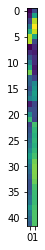

In [ ]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)
plt.imshow(pts[6])

# Data Visualisation
Here's an example of how to display the images and their points

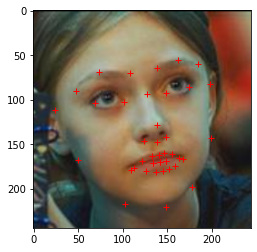

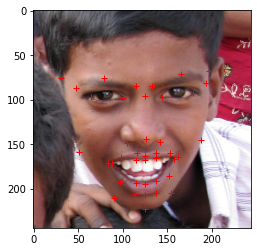

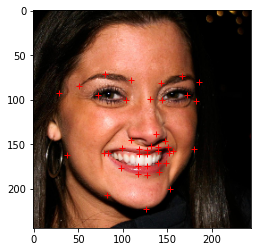

In [ ]:

def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

# Calculating Prediction Error and exporting results

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*42, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:

#test dataset used for testing
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)


#last 550 images used for validation data
x_val = images[-550:]
y_val = pts[-550:]

x_train = images[:-550]
y_train = pts[:-550]

#setting up training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=280).batch(64)

print(x_val.shape)
print('points',y_val.shape)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

val_dataset = val_dataset.batch(64)
print(val_dataset)

#method to build the model
def build_conv_model():
  #input shape
  inputs = tf.keras.Input(shape=(244, 244, 3))
  net = inputs

  #conv2D layer one
  conv1 = layers.Conv2D(filters = 32, kernel_size = 5, strides = (2, 2), padding = "same", activation = 'relu')
  net = conv1(net)
  net = layers.BatchNormalization()(net)
  net = layers.MaxPool2D()(net)

  #conv2D layer two
  conv2 = layers.Conv2D(filters = 64, kernel_size = 3, strides = (1,1), padding = 'same', activation = 'relu')
  net = conv2(net)
  net = layers.MaxPool2D()(net)

  #conv2D layer three
  conv3 = layers.Conv2D(filters = 128, kernel_size = 3, strides = (1, 1), padding = 'same', activation = 'relu')
  net =  conv3(net)
  net = layers.BatchNormalization()(net)
  net = layers.MaxPool2D()(net)


  #flatten the layers
  net = layers.Flatten()(net)

  #first dense using image shape
  dense1 = layers.Dense(units = 244, activation = 'relu')
  net = dense1(net)
  #second dense using points
  dense2 = layers.Dense(units = 84, activation='relu')
  net = dense2(net)

  #reshaping the points for the model
  net = layers.Reshape((42, 2))(net)

  return tf.keras.Model(inputs=inputs, outputs = net)

conv_model = build_conv_model()


(550, 244, 244, 3)
points (550, 42, 2)
<BatchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 42, 2), dtype=tf.float64, name=None))>


In [ ]:
#compile the training data
conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mse", metrics=["accuracy"])
#training method
hist = conv_model.fit(train_dataset, epochs=100, validation_data = val_dataset)

Epoch 1/100
36/36 [==============================] - 7s 138ms/step - loss: 3961.1177 - accuracy: 0.8367 - val_loss: 133841.5312 - val_accuracy: 0.9236
Epoch 2/100
36/36 [==============================] - 4s 102ms/step - loss: 358.2496 - accuracy: 0.9510 - val_loss: 2748.3945 - val_accuracy: 0.9165
Epoch 3/100
36/36 [==============================] - 4s 102ms/step - loss: 100.4379 - accuracy: 0.9619 - val_loss: 333.6817 - val_accuracy: 0.9483
Epoch 4/100
36/36 [==============================] - 4s 102ms/step - loss: 77.4073 - accuracy: 0.9648 - val_loss: 198.4906 - val_accuracy: 0.9594
Epoch 5/100
36/36 [==============================] - 4s 102ms/step - loss: 63.4610 - accuracy: 0.9678 - val_loss: 87.6003 - val_accuracy: 0.9640
Epoch 6/100
36/36 [==============================] - 4s 103ms/step - loss: 58.7488 - accuracy: 0.9690 - val_loss: 89.8416 - val_accuracy: 0.9685
Epoch 7/100
36/36 [==============================] - 4s 102ms/step - loss: 51.0330 - accuracy: 0.9704 - val_loss: 94.5

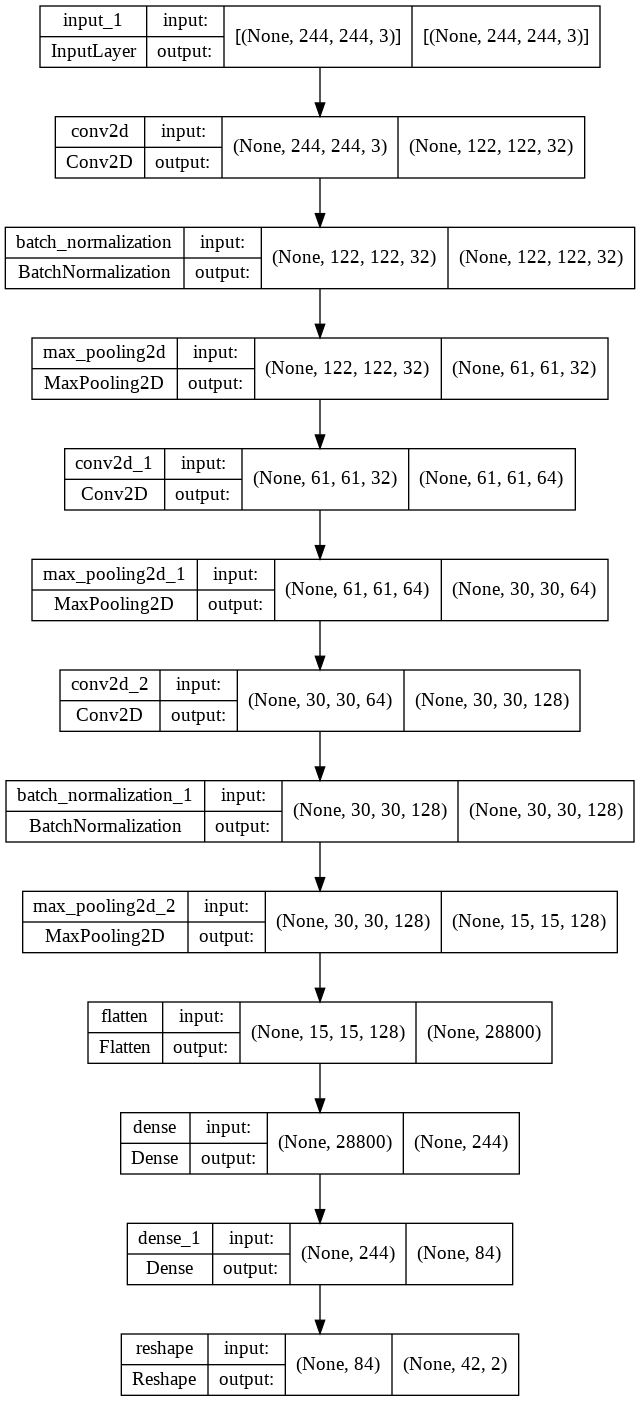

In [ ]:
from IPython.display import Image
tf.keras.utils.plot_model(conv_model, "conv_model.png", show_shapes=True)
#method for visual representation of layers
Image(retina=True, filename="conv_model.png")

In [ ]:

#final avg results of the training data
results = conv_model.evaluate(train_dataset, verbose=0)
print(results[0])
print(results[1])

6.391094207763672
0.9901960492134094


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


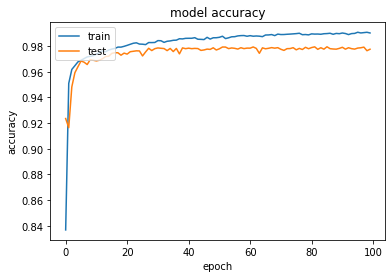

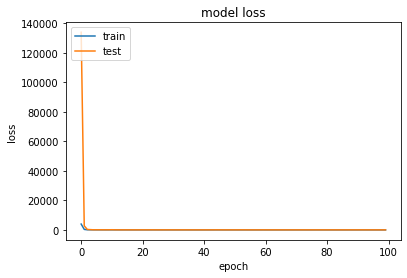

In [ ]:
print(hist.history.keys())
#plot for training, testing, model accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plot for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predict_pts = conv_model.predict(test_images)

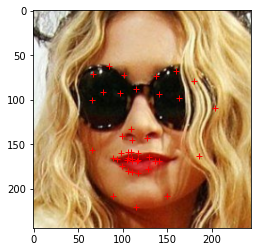

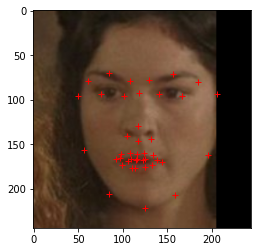

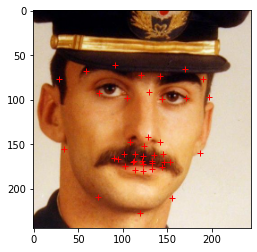

In [ ]:
def visualise_pts(img, pts):
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, test_images.shape[0])
  visualise_pts(test_images[idx, ...], predict_pts[idx, ...])
  #print(predict_pts[2])

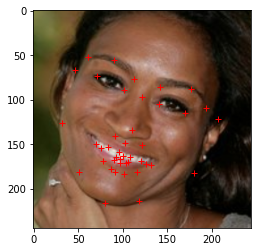

[[ 46.834335  66.2008  ]
 [ 31.825977 125.42805 ]
 [ 50.957386 180.88358 ]
 [ 80.56396  215.24142 ]
 [118.3611   213.69543 ]
 [179.79048  181.82156 ]
 [207.39865  121.45615 ]
 [ 60.8359    52.362118]
 [ 90.128136  55.074093]
 [112.71842   76.96608 ]
 [141.72186   85.87392 ]
 [177.12132   87.56985 ]
 [193.0884   108.90958 ]
 [121.990326  96.7554  ]
 [110.80103  133.62462 ]
 [ 91.2155   139.96864 ]
 [102.25739  148.65953 ]
 [121.887634 150.03722 ]
 [ 71.520744  73.5402  ]
 [101.87302   88.48223 ]
 [141.20847  104.43289 ]
 [169.83142  115.09029 ]
 [ 70.10061  149.87134 ]
 [ 83.773415 153.04047 ]
 [ 95.74412  158.1715  ]
 [100.521805 162.42915 ]
 [108.48332  164.13461 ]
 [120.277916 168.43356 ]
 [131.26897  173.52402 ]
 [116.17941  181.11299 ]
 [101.15009  183.29396 ]
 [ 91.66386  181.03395 ]
 [ 86.53376  177.04582 ]
 [ 77.546875 168.4984  ]
 [ 75.64725  153.69348 ]
 [ 92.21557  164.27716 ]
 [ 97.26328  166.57576 ]
 [105.820694 169.1063  ]
 [125.68509  172.42537 ]
 [103.39047  171.00945 ]


In [ ]:
#predict_pts[2][7]
#print(predict_pts[2][7])
#img = test_images[24]
#plt.imshow(img)
visualise_pts(test_images[10, ...], predict_pts[10, ...])
print(predict_pts[10])

In [ ]:
left_brow1 = predict_pts[10][7]
print(left_brow1)
left_brow2 = predict_pts[10][8]
print(left_brow2)
left_eye2 = predict_pts[10][18]
print(left_eye2)
img1 = test_images[10]
#plt.imshow(test_images[10])


img_points = np.array([[60.8359, 52.362118], [90.128136, 55.074093], [80, 80], [71.520744, 73.5402]], 'int32')

img2 = cv2.fillPoly(img1, pts=img_points, color=(0, 255, 0))

plt.imshow(img2)




NameError: ignored